## Building and training a CNN model

In [1]:
import sys
import os
import glob
import yaml
import typing
import numpy as np
import pandas as pd
import sklearn.metrics
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

# hint: notebook is executed in jupyter lab dark mode
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html for styles
# plt.style.use('dark_background')
# # global color settings (use white/grey for jupyterlab dark mode
# # and black/grey for jupyterlab light mode)
# COLOR = 'grey'
# plt.rcParams['text.color'] = COLOR
# plt.rcParams['axes.labelcolor'] = COLOR
# plt.rcParams['xtick.color'] = COLOR
# plt.rcParams['ytick.color'] = COLOR
# # plt.rcParams['grid.color'] = COLOR
# # plt.rcParams['figure.edgecolor'] = 'red'
plt.rcParams['figure.figsize'] = (12, 6)

print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'sklearn version: {sklearn.__version__}')
print(f'Tensorflow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

## the following code snippet is necessary for tensorflow 
## training to work (tf2.2, cuda10.2 or 10.1)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)

Using TensorFlow backend.


Python version: 3.8.3 (default, May 19 2020, 18:47:26) 
[GCC 7.3.0]
Numpy version: 1.18.1
Pandas version: 1.0.3
sklearn version: 0.22.1
Tensorflow version: 2.2.0
Keras version: 2.3.1


In [2]:
## model name:
MODEL_NAME = 'model1'

## create figure path if it does not exist
PATH_FIGURES = f'figs/models/{MODEL_NAME}/'
os.makedirs(PATH_FIGURES, exist_ok=True)

## location to save the models
PATH_MODEL = f'models/{MODEL_NAME}/'
os.makedirs(PATH_MODEL, exist_ok=True)

## random number generator seed:
RANDOM_STATE = 300

## use one of 'vgg16', 'resnet50v2', 'densenet121':
MODEL_ARCHITECTURE='densenet121'
INITIAL_LEARNING_RATE = 0.001
EPOCHS = 150
## image training parameters:
## use (224, 224, 3) for vgg16 model
## use (224, 224, 3) for resnet50v2 model
IMG_SIZE = (224, 224)
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_VALID = 16
BATCH_SIZE_TEST = 16
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.05
TEST_SIZE = 0.15
BALANCE_TRAINING_DATA = True
## in early stopping: how many epochs may the validation loss
## function not improve until we stop training
EARLY_STOPPING_PATIENCE = 50

## image data scaling (None, 'standardization', 'normalization'):
SCALE_TYPE = 'standardization'
## image augmentation:
# DICT_AUGMENTATION = {
#     'zca_whitening': False,
#     'horizontal_flip': True, 
#     'vertical_flip': False,
#     'height_shift_range': 0.05,
#     'width_shift_range': 0.1,
#     'rotation_range': 5,
#     'shear_range': 0.1,
#     'zoom_range': 0.15,
# }
DICT_AUGMENTATION = {
    'zca_whitening': False,
    'horizontal_flip': True, 
    'vertical_flip': False,
    'height_shift_range': 0,
    'width_shift_range': 0,
    'rotation_range': 0,
    'shear_range': 0,
    'zoom_range': 0,
}

## Data import and preprocessing:

In [3]:
## get data
df = pd.read_hdf('data_summary.hdf')
## convert class labels to string:
df['class_pneumonia'] = df['label_pneumonia'].astype('str')
df.head()

iid          finding_labels  nr_follow_up  pid  patient_age  \
0  00000001_000.png            cardiomegaly             0    1           58   
1  00000001_001.png  cardiomegaly|emphysema             1    1           58   
2  00000001_002.png   cardiomegaly|effusion             2    1           58   
3  00000002_000.png              no_finding             0    2           81   
4  00000003_000.png                  hernia             0    3           81   

  patient_gender view_position  oimage_width  oimage_height  \
0              m            pa          2682           2749   
1              m            pa          2894           2729   
2              m            pa          2500           2048   
3              m            pa          2500           2048   
4              f            pa          2582           2991   

   oimage_px_spacing_x  ...  label_fibrosis label_hernia  label_infiltration  \
0                0.143  ...               0            0                   0   
1                0.143  ...               0            0                   0   
2                0.168  ...               0            0                   0   
3                0.171  ...               0            0                   0   
4                0.143  ...               0            1                   0   

   label_mass  label_no_finding  label_nodule  label_pleural_thickening  \
0           0                 0             0                         0   
1           0                 0             0                         0   
2           0                 0             0                         0   
3           0                 1             0                         0   
4           0                 0             0                         0   

   label_pneumonia  label_pneumothorax  class_pneumonia  
0                0                   0                0  
1                0                   0                0  
2                0                   0                0  
3                0                   0                0  
4                0                   0                0  

[5 rows x 28 columns]

## Training, validation and testing data

In [56]:
def create_splits(df, train_size: float=0.8, valid_size: float=0.1, test_size: float=0.1,
                  random_state: typing.Union[None, int]=None) -> typing.List[pd.DataFrame]:
    """
    
    :param df:
    :param train_size: relative size of training dataset
    :param valid_size: relative size of validation dataset
    :param test_size: relative size of testing dataset
    :param random_state:
    :return:
    """
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    if 'pid' not in df:
        raise AttributeError("Feature 'pid' not available in df.")
    if 'label_pneumonia' not in df:
        raise AttributeError("Feature 'label_pneumonia' not available in df.")
    
    np.random.seed(seed=random_state)
    ## select all patients from the total dataset in random order
    pid_rand = np.random.choice(df['pid'].unique(), size=df['pid'].nunique(),
                                replace=False, p=None)
    pids_train = pid_rand[: int(df['pid'].nunique() * train_size)]
    pids_valid = pid_rand[
        int(df['pid'].nunique() * train_size): int(df['pid'].nunique() * (train_size + valid_size))
    ]
    pids_test = pid_rand[int(df['pid'].nunique() * (train_size + valid_size)):]
    ## get training dataset:
    df_train = df[df['pid'].isin(pids_train)]
    ## get validation dataset
    df_valid = df[df['pid'].isin(pids_valid)]
    ## get test dataset
    df_test = df[df['pid'].isin(pids_test)]
    return df_train, df_valid, df_test


def balance_dataset(df: pd.DataFrame, col_label: str,
                    random_state: typing.Union[None, int]=None) -> pd.DataFrame:
    """
    
    :param df:
    :param col_label:
    :param random_state:
    :return:
    """
    ## create a balanced training dataset by randomly selecting 
    ## negative samples and discarding the remaining:
    nr_samples = df[col_label].value_counts().min()
    df1 = pd.DataFrame([])
    for label in df[col_label].unique():
        df1 = df1.append(df[df[col_label]==label].sample(nr_samples, random_state=random_state))
    return df1


def data_split_analysis(df: pd.DataFrame, df_train: pd.DataFrame, df_valid: pd.DataFrame,
                        df_test: pd.DataFrame, df_train_sample: pd.DataFrame) -> pd.DataFrame:
    """
    
    :param df:
    :param df_train:
    :param df_valid:
    :param df_test:
    :param df_train_sample:
    :return:
    """
    df1 = pd.DataFrame(columns=['train', 'valid', 'test', 'train_sample', 'complete_dataset'])

    df1.loc['nr_patients'] = [
        df_train['pid'].nunique(), df_valid['pid'].nunique(), df_test['pid'].nunique(),
        df_train_sample['pid'].nunique(), df['pid'].nunique()
    ]
    df1.loc['cardinality'] = [
        df_train.shape[0], df_valid.shape[0], df_test.shape[0],
        df_train_sample.shape[0], df.shape[0]
    ]
    df1.loc['relative_cardinality'] = df1.loc['cardinality'] / df.shape[0]

    df1.loc['positie_samples'] = [
        df_train['label_pneumonia'].sum(), df_valid['label_pneumonia'].sum(),
        df_test['label_pneumonia'].sum(), df_train_sample['label_pneumonia'].sum(),
        df['label_pneumonia'].sum()
    ]
    df1.loc['negative_samples'] = df1.loc['cardinality'] - df1.loc['positie_samples']
    
    df1.loc['ratio_pos_neg_samples'] = (
        df1.loc['positie_samples'] / df1.loc['negative_samples']
    )

    df1.loc['age_mean'] = [
        df_train['patient_age'].mean(), df_valid['patient_age'].mean(),
        df_test['patient_age'].mean(), df_train_sample['patient_age'].mean(),
        df['patient_age'].mean()
    ]
    df1.loc['age_std'] = [
        df_train['patient_age'].std(), df_valid['patient_age'].std(),
        df_test['patient_age'].std(), df_train_sample['patient_age'].std(), 
        df['patient_age'].std()
    ]

    df1.loc['age_mean_positive_samples'] = [
        df_train.loc[df_train['label_pneumonia']==1, 'patient_age'].mean(),
        df_valid.loc[df_valid['label_pneumonia']==1, 'patient_age'].mean(),
        df_test.loc[df_test['label_pneumonia']==1, 'patient_age'].mean(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==1, 'patient_age'].mean(),
        df.loc[df['label_pneumonia']==1, 'patient_age'].mean()
    ]
    df1.loc['age_std_positive_samples'] = [
        df_train.loc[df_train['label_pneumonia']==1, 'patient_age'].std(),
        df_valid.loc[df_valid['label_pneumonia']==1, 'patient_age'].std(),
        df_test.loc[df_test['label_pneumonia']==1, 'patient_age'].std(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==1, 'patient_age'].std(),
        df.loc[df['label_pneumonia']==1, 'patient_age'].std()
    ]

    df1.loc['age_mean_negative_samples'] = [
        df_train.loc[df_train['label_pneumonia']==0, 'patient_age'].mean(),
        df_valid.loc[df_valid['label_pneumonia']==0, 'patient_age'].mean(),
        df_test.loc[df_test['label_pneumonia']==0, 'patient_age'].mean(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==0, 'patient_age'].mean(),
        df.loc[df['label_pneumonia']==0, 'patient_age'].mean()
    ]
    df1.loc['age_std_negative_samples'] = [
        df_train.loc[df_train['label_pneumonia']==0, 'patient_age'].std(),
        df_valid.loc[df_valid['label_pneumonia']==0, 'patient_age'].std(),
        df_test.loc[df_test['label_pneumonia']==0, 'patient_age'].std(),
        df_train_sample.loc[df_train_sample['label_pneumonia']==0, 'patient_age'].std(),
        df.loc[df['label_pneumonia']==0, 'patient_age'].std()
    ]

    df1.loc['females'] = [
        (df_train['patient_gender']=='f').sum(), (df_valid['patient_gender']=='f').sum(),
        (df_test['patient_gender']=='f').sum(), (df_train_sample['patient_gender']=='f').sum(),
        (df['patient_gender']=='f').sum()
    ]
    df1.loc['females_relative'] = df1.loc['females'] / df1.loc['cardinality']

    df1.loc['males'] = [
        (df_train['patient_gender']=='m').sum(), (df_valid['patient_gender']=='m').sum(),
        (df_test['patient_gender']=='m').sum(), (df_train_sample['patient_gender']=='m').sum(),
        (df['patient_gender']=='m').sum()
    ]
    df1.loc['males_relative'] = df1.loc['males'] / df1.loc['cardinality']

    df1.loc['pa_position'] = [
        (df_train['view_position']=='pa').sum(), (df_valid['view_position']=='pa').sum(),
        (df_test['view_position']=='pa').sum(), (df_train_sample['view_position']=='pa').sum(),
        (df['view_position']=='pa').sum()
    ]
    df1.loc['pa_position_relative'] = df1.loc['pa_position'] / df1.loc['cardinality']

    df1.loc['ap_position'] = [
        (df_train['view_position']=='ap').sum(), (df_valid['view_position']=='ap').sum(),
        (df_test['view_position']=='ap').sum(), (df_train_sample['view_position']=='ap').sum(),
        (df['view_position']=='ap').sum()
    ]
    df1.loc['ap_position_relative'] = df1.loc['ap_position'] / df1.loc['cardinality']
    return df1


def get_classes(predictions: np.array, thresh: float=0.5) -> np.array:
    """
    
    """
    classes = predictions.copy()
    classes[classes>=thresh] = 1
    classes[classes<thresh] = 0
    return classes


def evaluation_metrics(y_true, y_pred, y_pred_proba):
    """
    
    """
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
        y_true=y_true, y_pred=y_pred, labels=None,
        sample_weight=None, normalize=None
    ).ravel()
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(
        y_true=y_true, y_pred=y_pred,
        sample_weight=None, adjusted=False
    )
    f1 = sklearn.metrics.f1_score(
        y_true=y_true, y_pred=y_pred,
        labels=None, pos_label=1, average='binary',
        sample_weight=None, zero_division='warn'
    )
    recall = sklearn.metrics.recall_score(
        y_true=y_true, y_pred=y_pred, labels=None, pos_label=1,
        average='binary', sample_weight=None, zero_division='warn'
    )
    precision = sklearn.metrics.precision_score(
        y_true=y_true, y_pred=y_pred, labels=None, pos_label=1,
        average='binary', sample_weight=None, zero_division='warn'
    )
    auc = sklearn.metrics.roc_auc_score(
        y_true=y_true, y_score=y_pred_proba, average='macro',
        sample_weight=None, max_fpr=None, multi_class='raise', labels=None
    )
    
    dict_evals = {}
    dict_evals['tp'] = tp
    dict_evals['tn'] = tn
    dict_evals['fn'] = fn
    dict_evals['fp'] = fp
    dict_evals['f1'] = f1
    dict_evals['precision'] = precision
    dict_evals['recall'] = recall
    dict_evals['balanced_accuracy'] = balanced_accuracy
    dict_evals['auc'] = auc
    return dict_evals


def plot_confusion_matrix(tp, tn, fp, fn):
    """
    
    """
    df_cm = pd.DataFrame([[tn,fp], [fn, tp]], index=range(2), columns=range(2))
    sns.set(font_scale=1.4) # for label size
    ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt="d") # font size
    _ = ax.set(xlabel='predictions', ylabel='labels', title='Confusion matrix')
    return ax


def plot_precision_recall_curve(y_true, y_pred_proba):
    """
    
    """
    precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(
        y_true=y_true, probas_pred=y_pred_proba,
        pos_label=True, sample_weight=None
    )

    fig, ax = plt.subplots()
    lw = 2
    ax.plot(recalls, precisions, color='darkorange',
            lw=lw, label='Precision-recall curve')
    # ax.set_xlim([0.0, 1.0])
    # ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision-recall curve')
    # ax.legend(loc="lower right")
    fig.tight_layout()
    return ax


def plot_auc(y_true, y_pred_proba):
    """
    
    """
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true=y_true, y_score=y_pred_proba)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    # test_gen.reset
    # # Compute micro-average ROC curve and ROC area
    # fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(y_true=labels, y_score=predictions)
    # roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)

    fig, ax = plt.subplots()
    lw = 2
    ax.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(loc="lower right")
    fig.tight_layout()
    return ax, fpr, tpr


def plot_history(history):
    """
    plotting the history of model training
    """
    N = len(history.history['loss'])
    fig, ax = plt.subplots()
    ax.plot(np.arange(0, N), history.history['loss'], label='train_loss')
    ax.plot(np.arange(0, N), history.history['val_loss'], label='val_loss')
#     plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
#     plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    ax.set_title('Training and Validation Loss on Dataset')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Loss')
    ax.legend(loc='lower left')
    fig.tight_layout()
    return ax


def image_augmentation(df_train_sample: typing.Union[None, pd.DataFrame]=None,
                       scale_type: str='normalization', **kwargs_augmentation) -> ImageDataGenerator:
    """
    :param df_train_sample: (optional) needed if scale_type=='standardization'
    :param scale_type: one of None, 'normalization', 'standardization'
    :kwargs_augmentation: augmentation parameters. can contain: 'zca_whitening', 'horizontal_flip', 'vertical_flip',
        'height_shift_range', 'width_shift_range', 'rotation_range', 'shear_range', 'zoom_range'
    """
    if not scale_type:
        FEATUREWISE_CENTER = False
        FEATUREWISE_STD_NORMALIZATION = False
        RESCALE = None
        train_sample_mean = None
        train_sample_std = None
    elif scale_type.lower()=='standardization':
        train_sample_idg = ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True
        )
        train_sample_gen = train_sample_idg.flow_from_dataframe(
            dataframe=df_train_sample, 
            x_col='file_path',
            y_col='class_pneumonia',
            class_mode='binary',
            color_mode='rgb',
            seed=RANDOM_STATE,
            batch_size=df_train_sample.shape[0],
            target_size=(1024, 1024),
            interpolation='nearest'
        )

        ## import a sample of the training data
        ## (should be representative for the whole dataset):
        x_train_sample, _ = train_sample_gen.next()
        ## calculate the mean and std of this sample data,
        ## this mean and std will be used for standardization
        train_sample_mean = np.array([x_train_sample[:,:, :, i].mean() for i in (0, 1, 2)])
        train_sample_std = np.array([x_train_sample[:,:, :, i].std() for i in (0, 1, 2)])
        
        FEATUREWISE_CENTER = True
        FEATUREWISE_STD_NORMALIZATION = True
        RESCALE = None
    elif scale_type.lower()=='normalization':
        FEATUREWISE_CENTER = False
        FEATUREWISE_STD_NORMALIZATION = False
        RESCALE = 1. / 255.0
        train_sample_mean = None
        train_sample_std = None
    else:
        raise NotImplementedError("Scaling type must be either 'standardization', 'normalization' or None")

    print('Scaling type settings:')
    print(f'\t- featurewise_center: {FEATUREWISE_CENTER}')
    print(f'\t- featurewise_std_normalization: {FEATUREWISE_STD_NORMALIZATION}')
    print(f'\t- rescale: {RESCALE}')

    # define augmentation dictionary with default values:
    dict_augmentation = {
        'zca_whitening': False,
        'horizontal_flip': False, 
        'vertical_flip': False, 
        'height_shift_range': 0, 
        'width_shift_range': 0, 
        'rotation_range': 0,
        'shear_range': 0,
        'zoom_range': 0,
    }
    # overwrite default values:
    for key, val in kwargs_augmentation.items():
        dict_augmentation[key] = val
    print('Augmentation settings:')
    for key, val in dict_augmentation.items():
        print(f'\t- {key}: {val}')
        
    ## data augmentation on the training set:
    train_idg = ImageDataGenerator(
        ## use the following two arguments for standardization 
        featurewise_center=FEATUREWISE_CENTER,
        featurewise_std_normalization=FEATUREWISE_STD_NORMALIZATION,
        ## use the rescale argument for scaling images:
        rescale=RESCALE,
        **dict_augmentation
    )
    train_idg.mean = train_sample_mean
    train_idg.std = train_sample_std
    
    # Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
    val_idg = ImageDataGenerator(
        ## use the following two arguments for standardization 
        featurewise_center=FEATUREWISE_CENTER,
        featurewise_std_normalization=FEATUREWISE_STD_NORMALIZATION,
        ## use the rescale argument for scaling images:
        rescale=RESCALE
    )
    val_idg.mean = train_sample_mean
    val_idg.std = train_sample_std

    test_idg = ImageDataGenerator(
        ## use the following two arguments for standardization 
        featurewise_center=FEATUREWISE_CENTER,
        featurewise_std_normalization=FEATUREWISE_STD_NORMALIZATION,
        ## use the rescale argument for scaling images:
        rescale=RESCALE
    )
    test_idg.mean = train_sample_mean
    test_idg.std = train_sample_std

    return train_idg, val_idg, test_idg


def load_pretrained_model(model_architecture='vgg16'):
    """
    
    """
    if model_architecture.lower()=='vgg16':
        ## include_top: whether to include the 3 fully-connected layers at the top of the network.
        model = keras.applications.VGG16(include_top=True, weights='imagenet')
        ## create own model by removing last (dense) layers
        transfer_layer = model.get_layer('block5_pool')
        model = keras.models.Model(
            inputs=model.input,
            outputs=transfer_layer.output
        )
        ## return last convolutional layer for Grad-CAM (heatmap) alg.:
        last_conv_layer = model.get_layer('block5_conv3')
        ## choose which layers of VGG16 we actually want to fine-tune (if any)
        ## Here, we'll freeze all but the last convolutional layer
        for layer in model.layers[0:17]:
            layer.trainable = False
    elif model_architecture.lower()=='resnet50v2':
        model = keras.applications.ResNet50V2(
            include_top=True,
            weights='imagenet',
            input_tensor=None,
            input_shape=None,
            pooling=None,
            classes=1000,
        )
        transfer_layer = model.get_layer('post_relu')
        model = keras.models.Model(
            inputs=model.input,
            outputs=transfer_layer.output
        )
        ## TODO: return last convolutional layer for Grad-CAM (heatmap) alg.:
        last_conv_layer = None
        ## choose which layers of resnet50v2 we actually want to fine-tune (if any)
        ## Here, we'll freeze all but the last convolutional block (we train a fiew
        ## convolutional layers, batch norm layers etc.)
        for layer in model.layers[:-13]:
            layer.trainable = False
    elif model_architecture.lower()=='densenet121':
        model = keras.applications.DenseNet121(
            include_top=True,
            weights='imagenet',
            input_tensor=None,
            input_shape=None,
            pooling=None,
            classes=1000,
        )
        transfer_layer = model.get_layer('relu')
        model = keras.models.Model(
            inputs=model.input,
            outputs=transfer_layer.output
        )
        ## TODO: return last convolutional layer for Grad-CAM (heatmap) alg.:
        last_conv_layer = None
        ## choose which layers of densnet121 we actually want to fine-tune (if any)
        ## Here, we'll freeze all but the last 2 convolutional layers and relu/bn layers:
        for layer in model.layers[:-7]:
            layer.trainable = False
    else:
        raise NotImplementedError('Model has not been implemented yet')
    return model, last_conv_layer


def build_model(pretrained_model):
    """
    Add additional layers for classification (Flatten, Dense, Dropout, etc.)
    to the pre-trained model for fine-tuning.

    STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
    to output class activation maps to aid in clinical interpretation of your model's results
    """    
    model = keras.models.Sequential()
    ## Add the convolutional part of the pretrained model
    model.add(pretrained_model)

    ## average the activations across each part of the image
    ## what does global average pooling do: the Kernel size is 
    ## of dimensions H x W. So, it takes the Global Average 
    ## across Height and Width and gives you a tensor with 
    ## dimensions of 1xC for an input of H x W x C
    model.add(keras.layers.GlobalAveragePooling2D())
    ## Flatten the output of the pretrained model because it is from a
    ## convolutional layer.
    # model.add(keras.layers.Flatten())
    ## Add a dropout-layer which may prevent overfitting and
    ## improve generalization ability to unseen data e.g. the test-set.
#     model.add(keras.layers.Dropout(0.5))
    ## Add a dense (aka. fully-connected) layer.
    ## This is for combining features that the pretrained model has
    ## recognized in the image.
    model.add(
        keras.layers.Dense(
            units=1024, activation='relu',
            use_bias=True,
            kernel_initializer='he_normal',
            bias_initializer='zeros',
            activity_regularizer=None
        )
    )
    model.add(keras.layers.Dropout(0.5))
    model.add(
        keras.layers.Dense(
            units=512, activation='relu',
            use_bias=True,
            kernel_initializer='he_normal',
            bias_initializer='zeros',
            activity_regularizer=None
        )
    )
    model.add(keras.layers.Dropout(0.5))
    model.add(
        keras.layers.Dense(
            units=256, activation='relu',
            use_bias=True,
            kernel_initializer='he_normal',
            bias_initializer='zeros',
            activity_regularizer=None
        )
    )
    ## Add a dense (aka. fully-connected) layer.
    ## Change the activation function to sigmoid 
    ## so output of the last layer is in the range of [0,1]
    ## and thus represents a probability:
    model.add(
        keras.layers.Dense(
            units=1, activation='sigmoid',
            kernel_initializer='glorot_uniform',
        ))
    return model

In [5]:
df_train, df_valid, df_test = create_splits(df=df, train_size=TRAIN_SIZE, valid_size=VALIDATION_SIZE,
                                            test_size=TEST_SIZE, random_state=RANDOM_STATE)
if BALANCE_TRAINING_DATA:
    # we remove some negative training samples to achieve balanced classes:
    df_train = balance_dataset(df=df_train, col_label='label_pneumonia', random_state=RANDOM_STATE)
# randomly select a representative sample for standardization:
df_train_sample = df_train.sample(n=500, random_state=RANDOM_STATE)
df_datasets_info = data_split_analysis(df=df, df_train=df_train, df_valid=df_valid,
                                       df_test=df_test, df_train_sample=df_train_sample)
df_datasets_info.to_hdf(path_or_buf=f'{PATH_MODEL}datasets_info.hdf', key='df')
df_datasets_info

/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/pandas/core/generic.py:2490: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer-float,key->block0_values] [items->Index(['train', 'valid', 'test', 'train_sample', 'complete_dataset'], dtype='object')]

  pytables.to_hdf(


train      valid       test train_sample  \
nr_patients                     1719       1540       4621          450   
cardinality                     2306       5836      16469          500   
relative_cardinality       0.0205702  0.0520588   0.146908   0.00446014   
positie_samples                 1153         86        191          252   
negative_samples                1153       5750      16278          248   
ratio_pos_neg_samples              1  0.0149565  0.0117336      1.01613   
age_mean                     46.2012    47.1498    46.3489       45.654   
age_std                      16.9012    17.2483    16.4045       16.797   
age_mean_positive_samples    45.0095    47.5233    41.3403      44.1746   
age_std_positive_samples     17.2934    19.5946    18.4261      17.4189   
age_mean_negative_samples    47.3929    47.1442    46.4077      47.1573   
age_std_negative_samples     16.4209    17.2126    16.3708       16.036   
females                         1002       2478       7037          224   
females_relative            0.434519   0.424606   0.427288        0.448   
males                           1304       3358       9432          276   
males_relative              0.565481   0.575394   0.572712        0.552   
pa_position                     1217       3256       9992          276   
pa_position_relative        0.527754   0.557916   0.606716        0.552   
ap_position                     1089       2580       6477          224   
ap_position_relative        0.472246   0.442084   0.393284        0.448   

                          complete_dataset  
nr_patients                          30802  
cardinality                         112104  
relative_cardinality                     1  
positie_samples                       1430  
negative_samples                    110674  
ratio_pos_neg_samples            0.0129208  
age_mean                           46.8726  
age_std                            16.5982  
age_mean_positive_samples          44.6706  
age_std_positive_samples           17.6391  
age_mean_negative_samples           46.901  
age_std_negative_samples           16.5824  
females                              48776  
females_relative                  0.435096  
males                                63328  
males_relative                    0.564904  
pa_position                          67299  
pa_position_relative              0.600326  
ap_position                          44805  
ap_position_relative              0.399674

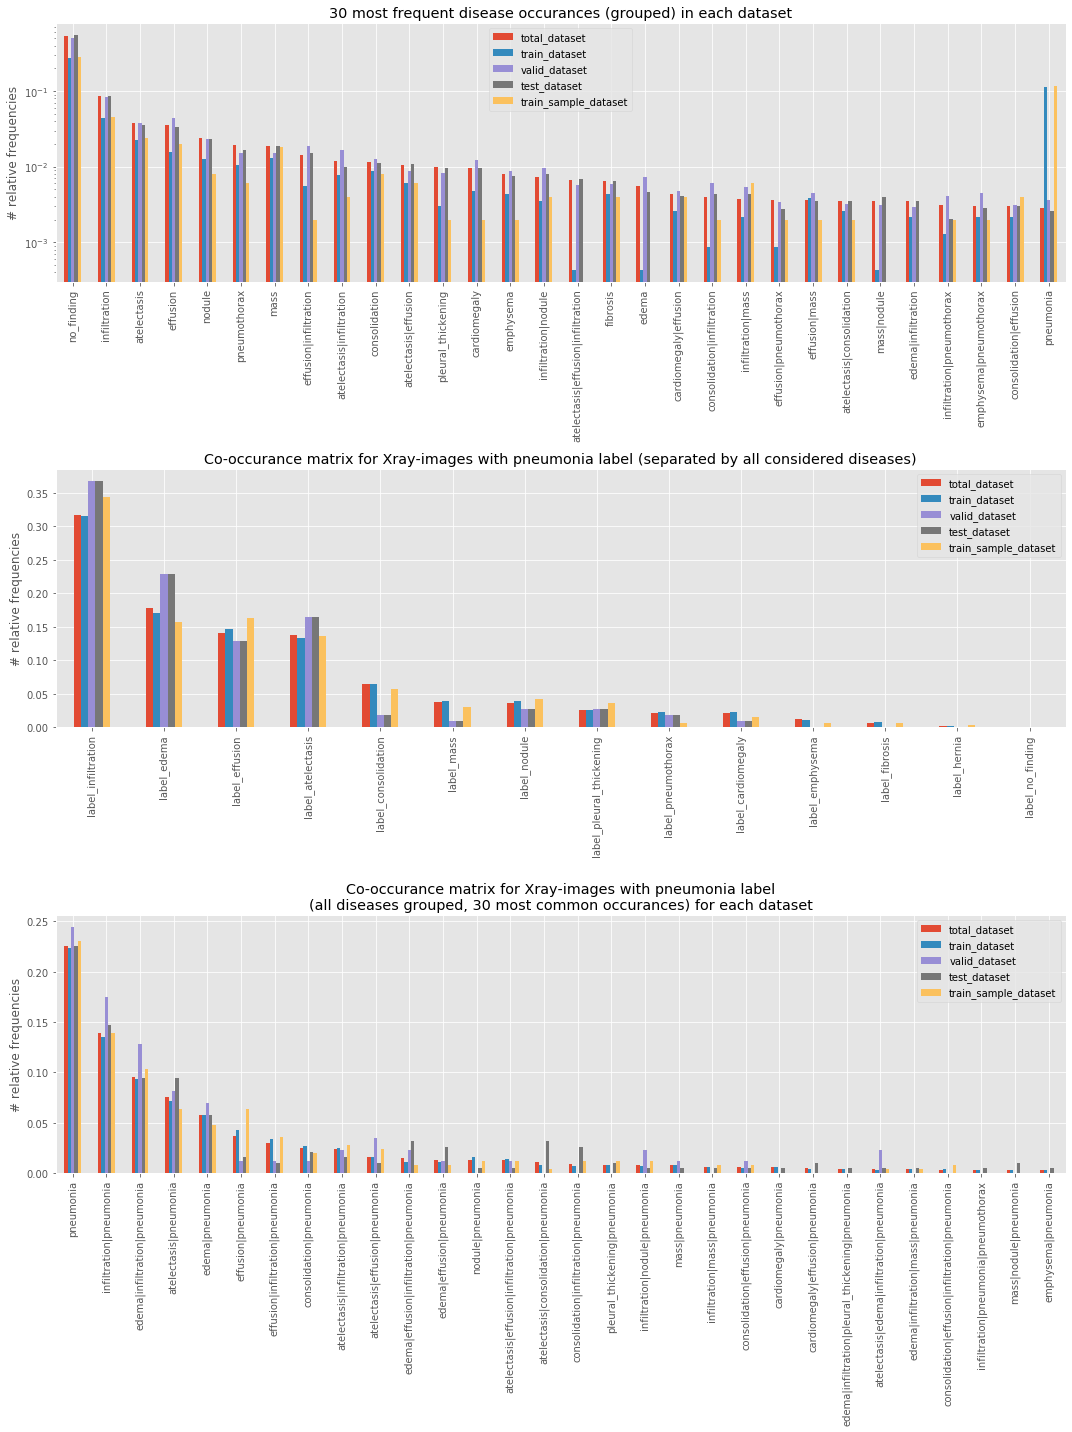

In [6]:
df_diseases = pd.DataFrame([])
df_diseases['total_dataset'] = df['finding_labels'].value_counts()
df_diseases['train_dataset'] = df_train['finding_labels'].value_counts()
df_diseases['valid_dataset'] = df_valid['finding_labels'].value_counts()
df_diseases['test_dataset'] = df_test['finding_labels'].value_counts()
df_diseases['train_sample_dataset'] = df_train_sample['finding_labels'].value_counts()
df_diseases_relative = df_diseases / df_diseases.sum()

dfa = pd.DataFrame([])
dfa['total_dataset'] = (
    df.loc[df['label_pneumonia']==1, df.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['train_dataset'] = (
    df_train.loc[df_train['label_pneumonia']==1, df_train.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['valid_dataset'] = (
    df_valid.loc[df_valid['label_pneumonia']==1, df_valid.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['test_dataset'] = (
    df_valid.loc[df_valid['label_pneumonia']==1, df_valid.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)
dfa['train_sample_dataset'] = (
    df_train_sample.loc[df_train_sample['label_pneumonia']==1, df_train_sample.columns.str.startswith('label')]
    .drop('label_pneumonia', axis=1)
    .sum()
    .sort_values(ascending=False)
)

dfa_relative = dfa / dfa.sum()

df_coocurrance = pd.DataFrame([])
df_coocurrance['total_dataset'] = df.loc[df['finding_labels'].str.contains('pneumonia'),
                                         'finding_labels'].value_counts()
df_coocurrance['train_dataset'] = df_train.loc[df_train['finding_labels'].str.contains('pneumonia'),
                                               'finding_labels'].value_counts()
df_coocurrance['valid_dataset'] = df_valid.loc[df_valid['finding_labels'].str.contains('pneumonia'),
                                               'finding_labels'].value_counts()
df_coocurrance['test_dataset'] = df_test.loc[df_test['finding_labels'].str.contains('pneumonia'),
                                             'finding_labels'].value_counts()
df_coocurrance['train_sample_dataset'] = df_train_sample.loc[df_train_sample['finding_labels'].str.contains('pneumonia'),
                                                             'finding_labels'].value_counts()
df_coocurrance_relative = df_coocurrance / df_coocurrance.sum()


fig, axarr = plt.subplots(3, 1, figsize=(15, 20))
ttl = '30 most frequent disease occurances (grouped) in each dataset'
df_diseases_relative[:30].plot.bar(ax=axarr[0], title=ttl, label='b', logy=True)
axarr[0].set_ylabel('# relative frequencies')

ttl = 'Co-occurance matrix for Xray-images with pneumonia label (separated by all considered diseases)'
dfa_relative.plot.bar(ax=axarr[1], title=ttl)
axarr[1].set_ylabel('# relative frequencies')

ttl = 'Co-occurance matrix for Xray-images with pneumonia label\n(all diseases grouped, 30 most common occurances) for each dataset'
df_coocurrance_relative.head(30).plot.bar(ax=axarr[2], title=ttl)
axarr[2].set_ylabel('# relative frequencies')
fig.tight_layout()

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
train_idg, val_idg, test_idg = image_augmentation(df_train_sample=df_train_sample, scale_type=SCALE_TYPE, **DICT_AUGMENTATION)

Found 500 validated image filenames belonging to 2 classes.


/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ud/miniconda3/envs/py38ml/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Scaling type settings:
	- featurewise_center: True
	- featurewise_std_normalization: True
	- rescale: None
Augmentation settings:
	- zca_whitening: False
	- horizontal_flip: True
	- vertical_flip: False
	- height_shift_range: 0
	- width_shift_range: 0
	- rotation_range: 0
	- shear_range: 0
	- zoom_range: 0


In [8]:
train_idg.mean

array([124.47218, 124.47218, 124.47218], dtype=float32)

In [9]:
train_idg.std

array([64.32632, 64.32632, 64.32632], dtype=float32)

In [10]:
## Create actual generators using the output of image augmentation 
## (ImageDataGenerator()) for training data:
train_gen = train_idg.flow_from_dataframe(
    dataframe=df_train, 
    directory=None, 
    x_col='file_path',
    y_col='class_pneumonia',
    class_mode='binary',
    color_mode='rgb',
    weight_col=None,
    shuffle=True,
    seed=RANDOM_STATE,
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE_TRAIN,
    interpolation='nearest'
)
## Create actual generators using the output of image augmentation 
## (ImageDataGenerator()) for validation data:
## IMPORTANT: we may not shuffle the dataset because we want to match
## predictions to labels later (use val_gen.reset before each use of
## val_gen)
val_gen = val_idg.flow_from_dataframe(
    dataframe=df_valid, 
    directory=None, 
    x_col='file_path',
    y_col='class_pneumonia',
    class_mode='binary',
    color_mode='rgb',
    weight_col=None,
    shuffle=False,
    seed=RANDOM_STATE,
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE_VALID,
    interpolation='nearest'
)
## Create actual generators using the output of image augmentation 
## (ImageDataGenerator()) for validation data:
## IMPORTANT: we may not shuffle the dataset because we want to match
## predictions to labels later (use test_gen.reset before each use of
## test_gen)
test_gen = test_idg.flow_from_dataframe(
    dataframe=df_test, 
    directory=None, 
    x_col='file_path',
    y_col='class_pneumonia',
    class_mode='binary',
    color_mode='rgb',
    weight_col=None,
    shuffle=False,
    seed=RANDOM_STATE,
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE_TEST,
    interpolation='nearest'
)

Found 2306 validated image filenames belonging to 2 classes.
Found 5836 validated image filenames belonging to 2 classes.
Found 16469 validated image filenames belonging to 2 classes.


In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
# valX, valY = val_gen.next()

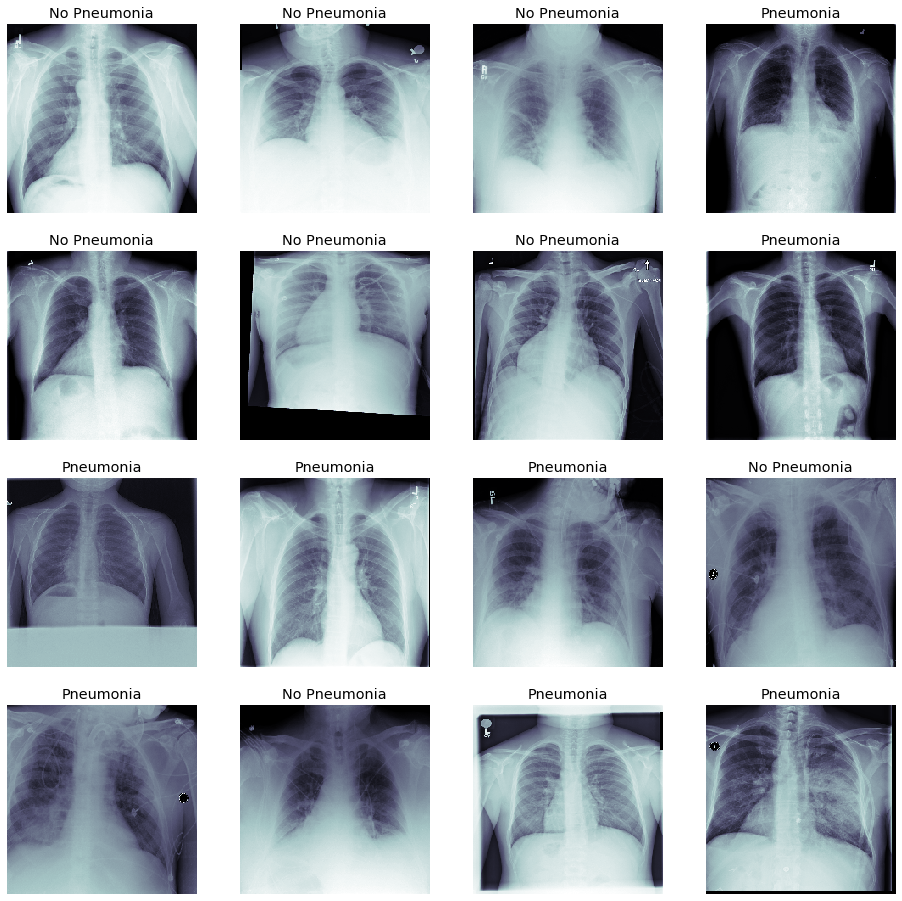

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
model_pretrained, last_conv_layer = load_pretrained_model(model_architecture=MODEL_ARCHITECTURE)
model = build_model(pretrained_model=model_pretrained)
model_pretrained.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [15]:
## Set our optimizer, loss function, and learning rate
optimizer = keras.optimizers.Adam(
    lr=INITIAL_LEARNING_RATE, beta_1=0.9,
    beta_2=0.999
)
loss = 'binary_crossentropy'
metrics = [
    keras.metrics.BinaryAccuracy(name="binary_accuracy", threshold=0.5),
    keras.metrics.Precision(thresholds=0.5, name='precision'),
    keras.metrics.Recall(thresholds=0.5, name='recall'),
    keras.metrics.TruePositives(thresholds=0.5, name='tp'),
    keras.metrics.TrueNegatives(thresholds=0.5, name='tn'),
    keras.metrics.FalsePositives(thresholds=0.5, name='fp'),
    keras.metrics.FalseNegatives(thresholds=0.5, name='fn'),
    keras.metrics.AUC(name='auc')
]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [16]:
## add checkpoints to the model
## save 'best' version of model by comparing it to previous epochs of training

## monitor the validation loss metric to get the model's 'best' performance 
## The 'patience' parameter indicates how long the model will train without
## seeing improvement before quitting

dir_weights = f'{PATH_MODEL}weights/'
## create (sub-) directories if they do not exist:
os.makedirs(dir_weights, exist_ok=True)
## do not overwrite weights:
# path_weights = dir_weights + 'weights_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.hdf5'
## overwrite weights:
path_weights = f'{dir_weights}weights.hdf5'

cb_save_weights = keras.callbacks.ModelCheckpoint(
    filepath=path_weights, 
    monitor='val_loss',
    mode='min',
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True
)

cb_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=EARLY_STOPPING_PATIENCE,
    restore_best_weights=True
)

cb_reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.2,
    patience=5,
    min_lr=1e-7)

lst_callbacks = [cb_save_weights, cb_early_stopping, cb_reduce_lr]

### Start training! 

In [17]:
## train model:
history = model.fit(train_gen, 
                    validation_data=val_gen,
                    validation_freq=1,
                    epochs=EPOCHS,
                    callbacks=lst_callbacks)

Epoch 1/150
145/145 [==============================] - 488s 3s/step - loss: 0.9696 - binary_accuracy: 0.5069 - precision: 0.5067 - recall: 0.5265 - tp: 607.0000 - tn: 562.0000 - fp: 591.0000 - fn: 546.0000 - auc: 0.5170 - val_loss: 0.6873 - val_binary_accuracy: 0.3355 - val_precision: 0.0166 - val_recall: 0.7558 - val_tp: 65.0000 - val_tn: 1893.0000 - val_fp: 3857.0000 - val_fn: 21.0000 - val_auc: 0.5912

Epoch 00001: val_loss improved from inf to 0.68729, saving model to models/model1/weights/weights.hdf5
Epoch 2/150
145/145 [==============================] - 75s 520ms/step - loss: 0.7177 - binary_accuracy: 0.5598 - precision: 0.5582 - recall: 0.5742 - tp: 662.0000 - tn: 629.0000 - fp: 524.0000 - fn: 491.0000 - auc: 0.5762 - val_loss: 0.7345 - val_binary_accuracy: 0.3446 - val_precision: 0.0175 - val_recall: 0.7907 - val_tp: 68.0000 - val_tn: 1943.0000 - val_fp: 3807.0000 - val_fn: 18.0000 - val_auc: 0.6373

Epoch 00002: val_loss did not improve from 0.68729
Epoch 3/150
145/145 [=====

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [18]:
## output final optimizer configs (e.g. learning rate)
model.optimizer.get_config()

{'learning_rate': 1.0000000116860974e-07,
 'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-07,
 'amsgrad': False}

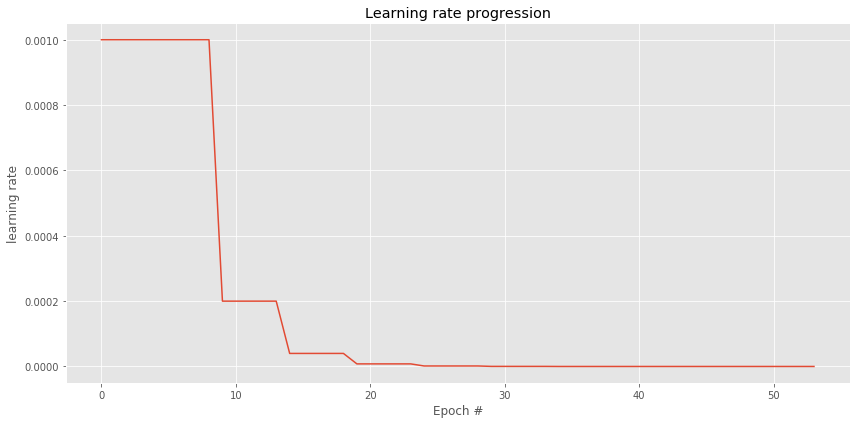

In [19]:
fig, ax = plt.subplots()
plt.plot(history.history['lr'])
ax.set_title("Learning rate progression")
ax.set_xlabel("Epoch #")
ax.set_ylabel("learning rate")
fig.tight_layout()

In [20]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
model.load_weights(path_weights)

train_gen.reset
y_pred_train = model.predict(train_gen, verbose=1)

val_gen.reset
y_pred_val = model.predict(val_gen, verbose=1)

test_gen.reset
y_pred_test = model.predict(test_gen, verbose=1)

1030/1030 [==============================] - 499s 485ms/step


In [81]:
thresh = 0.5
## get class predictions:
y_pred_classes_train = get_classes(predictions=y_pred_train, thresh=thresh)
y_pred_classes_val = get_classes(predictions=y_pred_val, thresh=thresh)
y_pred_classes_test = get_classes(predictions=y_pred_test, thresh=thresh)

train_gen.reset
dict_evals_train = evaluation_metrics(
    y_true=np.array(train_gen.labels).ravel(),
    y_pred=y_pred_classes_train.ravel(),
    y_pred_proba=y_pred_train.ravel()
)
val_gen.reset
dict_evals_valid = evaluation_metrics(
    y_true=np.array(val_gen.labels).ravel(),
    y_pred=y_pred_classes_val.ravel(),
    y_pred_proba=y_pred_val.ravel()
)
test_gen.reset
dict_evals_test = evaluation_metrics(
    y_true=np.array(test_gen.labels).ravel(),
    y_pred=y_pred_classes_test.ravel(),
    y_pred_proba=y_pred_test.ravel()
)
print(f'training evaluation metrics (threshold: {thresh})')
_ = [print(f'\t{key}: {value}') for key, value in dict_evals_train.items()]
print(f'validation evaluation metrics (threshold: {thresh})')
_ = [print(f'\t{key}: {value}') for key, value in dict_evals_valid.items()]
print(f'test evaluation metrics (threshold: {thresh})')
_ = [print(f'\t{key}: {value}') for key, value in dict_evals_test.items()]


training evaluation metrics (threshold: 0.5)
	tp: 602
	tn: 539
	fn: 551
	fp: 614
	f1: 0.5082313212325876
	precision: 0.49506578947368424
	recall: 0.5221162185602776
	balanced_accuracy: 0.49479618386817004
	auc: 0.4910791186158662
validation evaluation metrics (threshold: 0.5)
	tp: 53
	tn: 3050
	fn: 33
	fp: 2700
	f1: 0.03733709052483268
	precision: 0.01925172539048311
	recall: 0.6162790697674418
	balanced_accuracy: 0.5733569261880688
	auc: 0.6385561172901921
test evaluation metrics (threshold: 0.5)
	tp: 117
	tn: 9634
	fn: 74
	fp: 6644
	f1: 0.033659378596087454
	precision: 0.017305132376867326
	recall: 0.612565445026178
	balanced_accuracy: 0.602203597313433
	auc: 0.6493825540397891


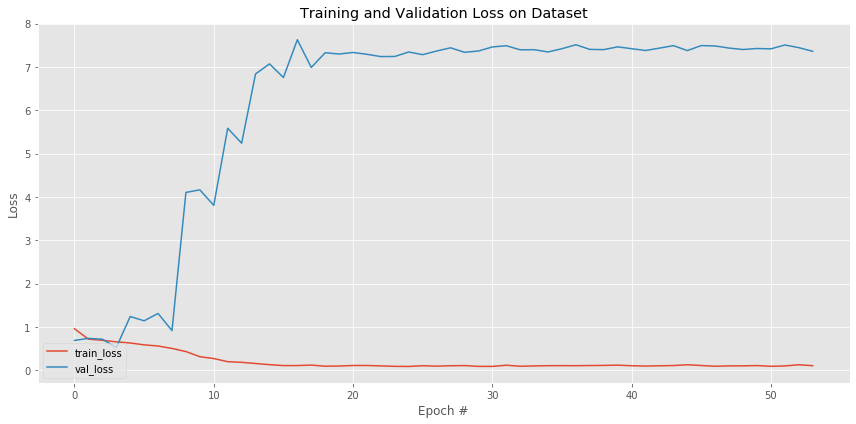

In [23]:
hst = plot_history(history=history)
plt.savefig(f'{PATH_FIGURES}train_valid_loss_progress.png', bbox_inches='tight')

### Plot validation metrics

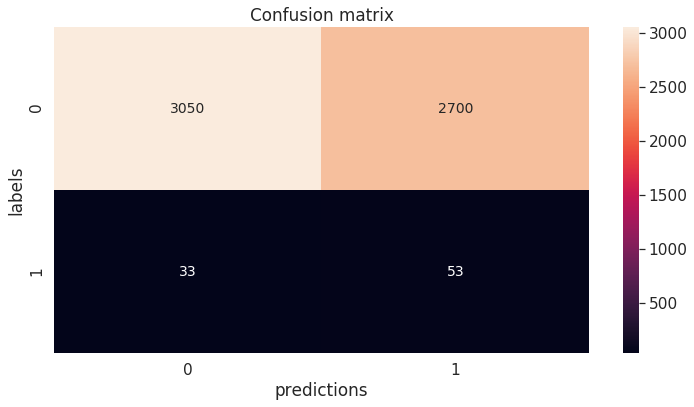

In [24]:
ax = plot_confusion_matrix(
    tp=dict_evals_valid['tp'], tn=dict_evals_valid['tn'],
    fp=dict_evals_valid['fp'], fn=dict_evals_valid['fn']
)
plt.savefig(f'{PATH_FIGURES}valid_confusion_matrix.png', bbox_inches='tight')

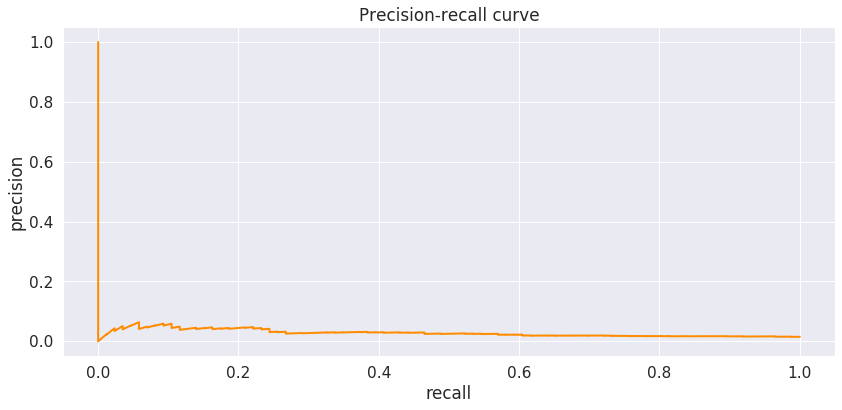

In [25]:
val_gen.reset
ax = plot_precision_recall_curve(
    y_true=np.array(val_gen.labels).ravel(),
    y_pred_proba=y_pred_val.ravel()
)
plt.savefig(f'{PATH_FIGURES}valid_precision_recall_curve.png', bbox_inches='tight')

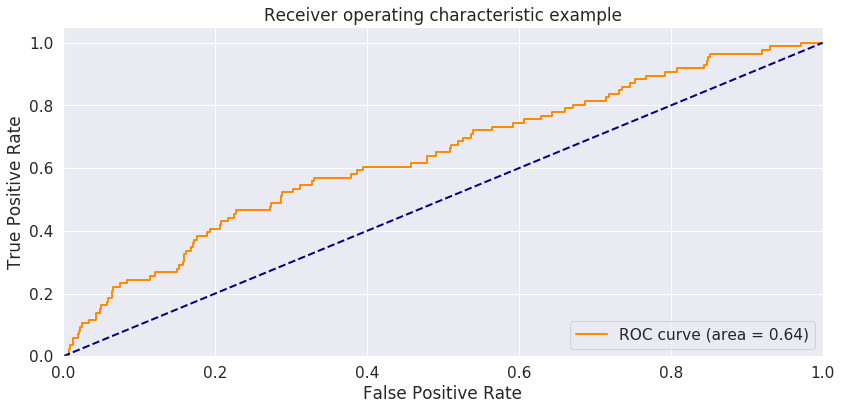

In [26]:
val_gen.reset
auc_ax, val_fpr, val_tpr = plot_auc(y_true=val_gen.labels, y_pred_proba=y_pred_val.ravel())
plt.savefig(f'{PATH_FIGURES}valid_roc_curve.png', bbox_inches='tight')

### Plot test metrics

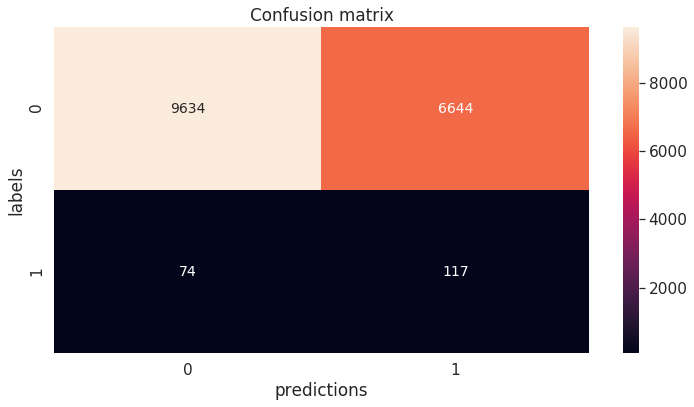

In [27]:
ax = plot_confusion_matrix(
    tp=dict_evals_test['tp'], tn=dict_evals_test['tn'],
    fp=dict_evals_test['fp'], fn=dict_evals_test['fn']
)
plt.savefig(f'{PATH_FIGURES}test_confusion_matrix.png', bbox_inches='tight')

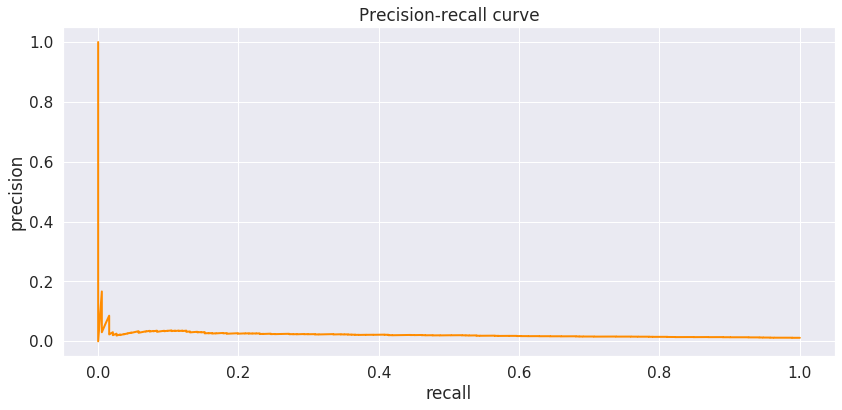

In [28]:
test_gen.reset
ax = plot_precision_recall_curve(
    y_true=np.array(test_gen.labels).ravel(),
    y_pred_proba=y_pred_test.ravel()
)
plt.savefig(f'{PATH_FIGURES}test_precision_recall_curve.png', bbox_inches='tight')

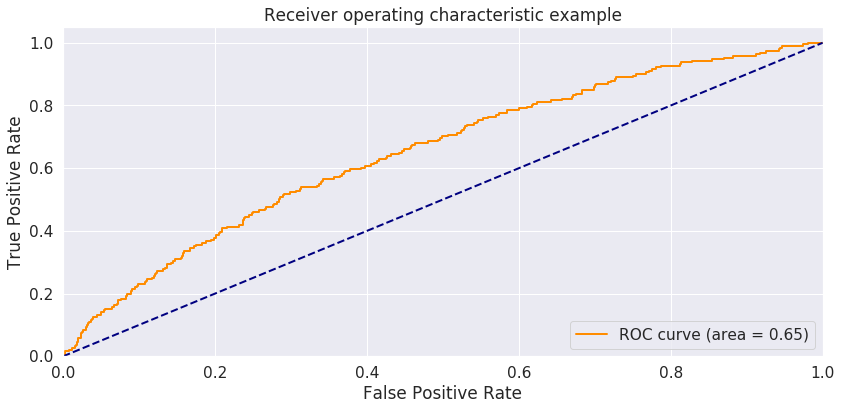

In [29]:
test_gen.reset
auc_ax, test_fpr, test_tpr = plot_auc(y_true=test_gen.labels, y_pred_proba=y_pred_test.ravel())
plt.savefig(f'{PATH_FIGURES}test_roc_curve.png', bbox_inches='tight')

In [30]:
# val_gen.reset()
# lst = model.evaluate_generator(generator=val_gen, verbose=1)

# test_gen.reset()
# model.evaluate_generator(generator=test_gen, verbose=1)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [31]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [32]:
THRESH = 0.5

Validation data visualization:


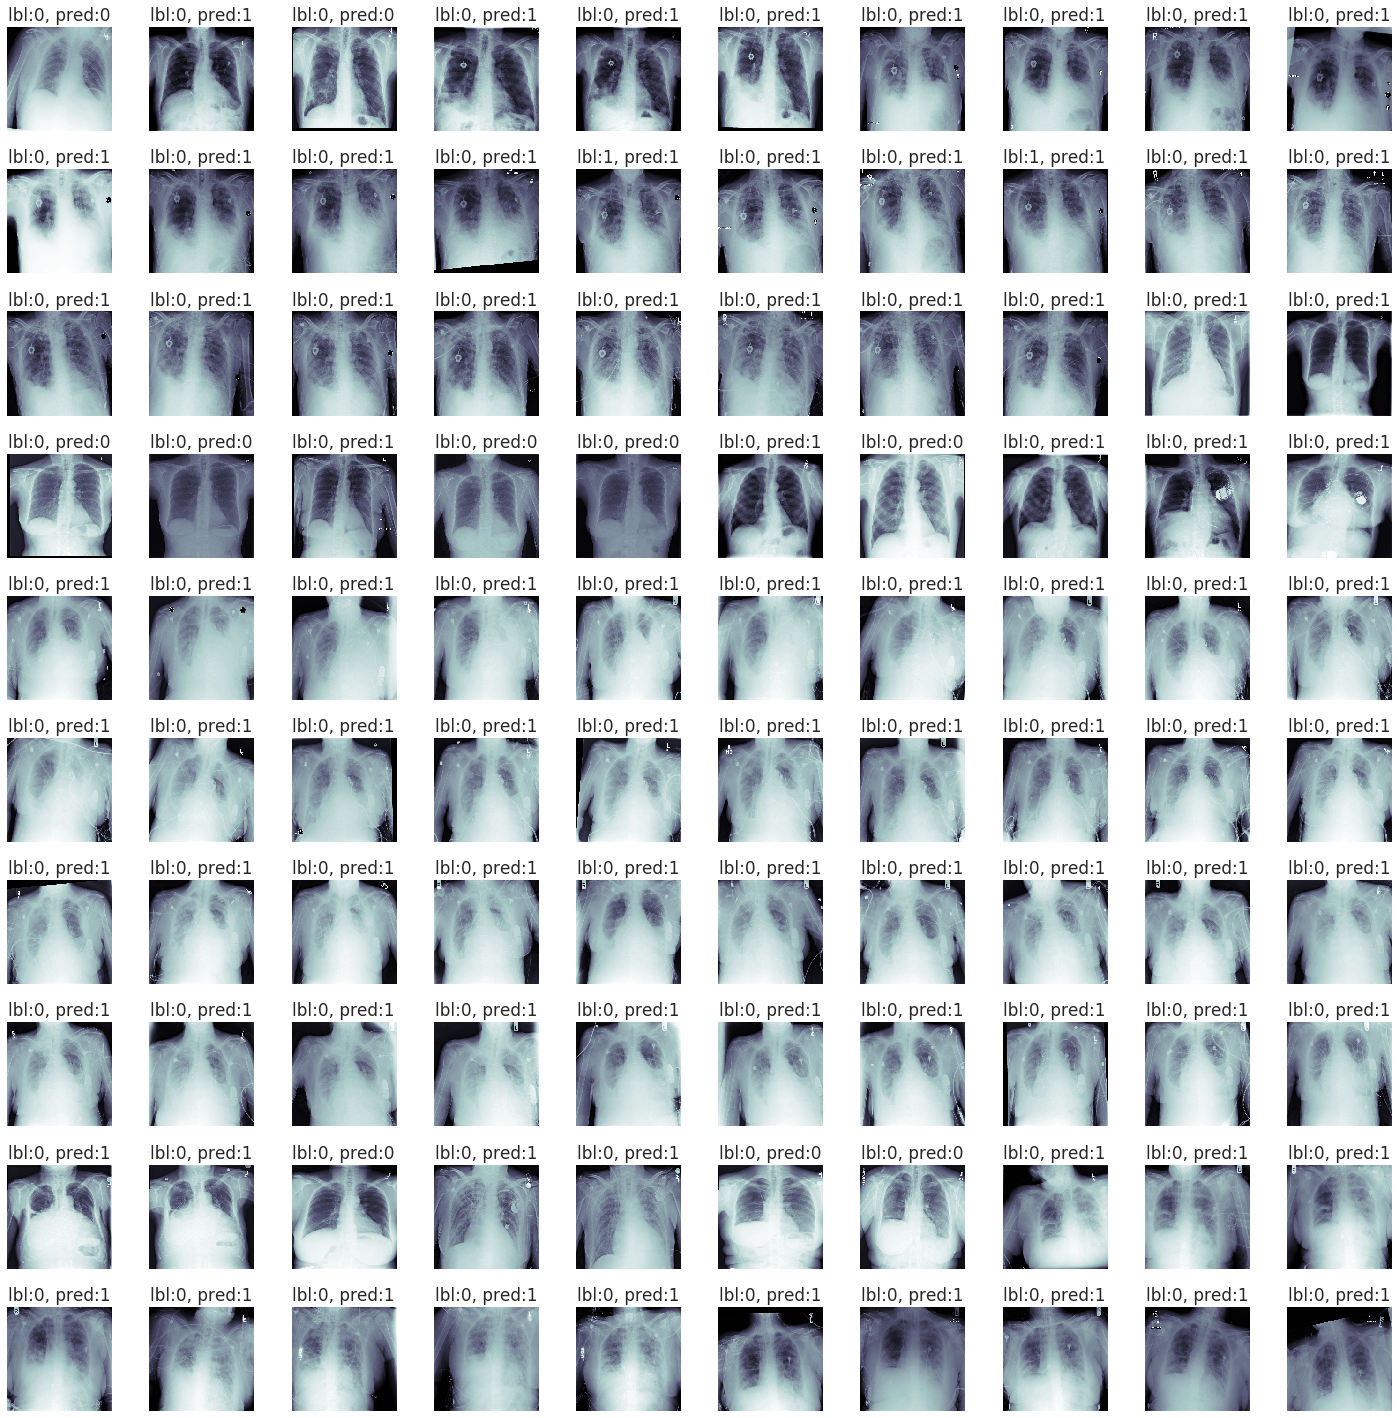

In [33]:
## Let's look at some examples of predicted v. true with our best model: 
print('Validation data visualization:')
val_gen.reset
val_labels = np.array([])
val_preds = []
while val_labels.size<100:
    gen = val_gen.next()
    val_labels = np.append(val_labels, gen[1])
    val_preds += [gen[0]]
val_preds = np.concatenate(val_preds, axis=0)

fig, m_axs = plt.subplots(10, 10, figsize = (20, 20))
i = 0
for (c_x, c_y, c_ax) in zip(val_preds[0:100], val_labels[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if y_pred_val[i] > THRESH:
            c_ax.set_title('lbl:1, pred:1')
        else:
            c_ax.set_title('lbl:1, pred:0')
    else:
        if y_pred_val[i] > THRESH: 
            c_ax.set_title('lbl:0, pred:1')
        else:
            c_ax.set_title('lbl:0, pred:0')
    c_ax.axis('off')
    i=i+1
fig.tight_layout()
plt.savefig(f'{PATH_FIGURES}validset_pneumonia_detection_vis.png', bbox_inches='tight')

Testing data visualization:


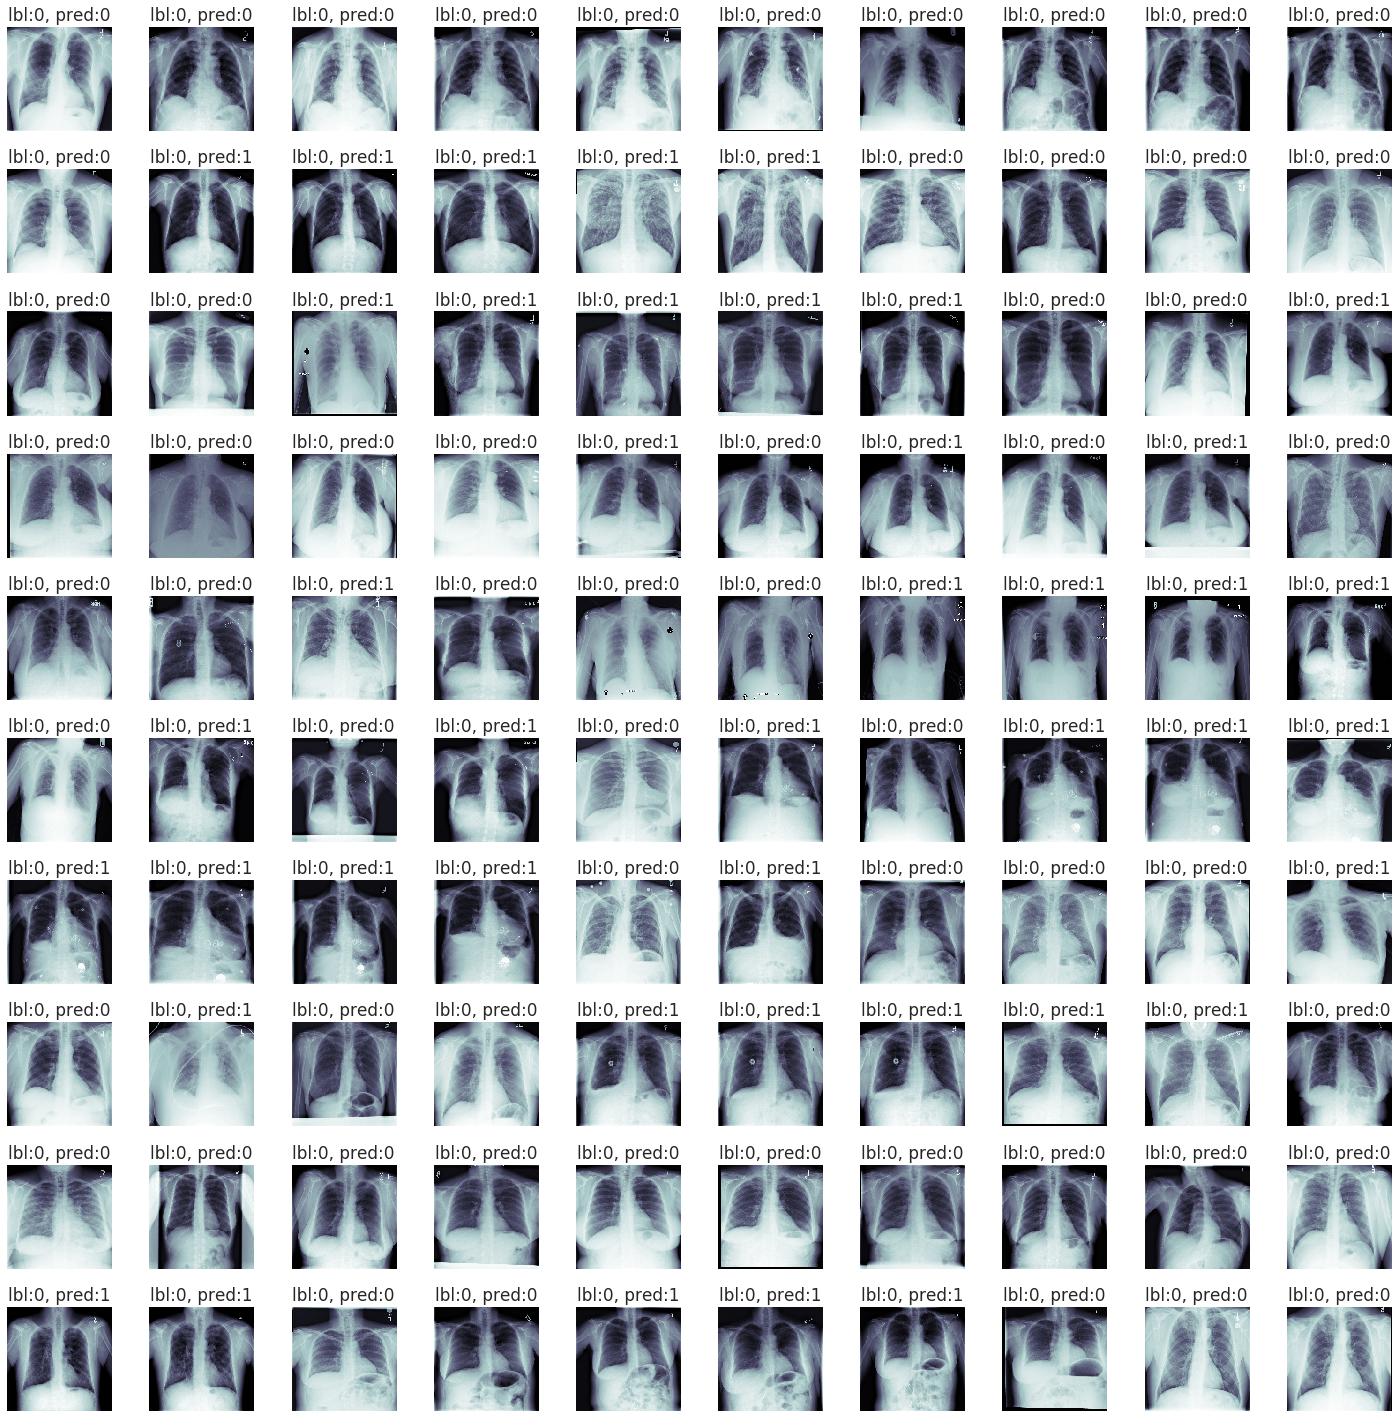

In [34]:
## Let's look at some examples of predicted v. true with our best model: 
print('Testing data visualization:')
test_gen.reset
test_labels = np.array([])
test_preds = []
while test_labels.size<100:
    gen = test_gen.next()
    test_labels = np.append(test_labels, gen[1])
    test_preds += [gen[0]]
test_preds = np.concatenate(test_preds, axis=0)

fig, m_axs = plt.subplots(10, 10, figsize = (20, 20))
i = 0
for (c_x, c_y, c_ax) in zip(test_preds[0:100], test_labels[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if y_pred_test[i] > THRESH:
            c_ax.set_title('lbl:1, pred:1')
        else:
            c_ax.set_title('lbl:1, pred:0')
    else:
        if y_pred_test[i] > THRESH: 
            c_ax.set_title('lbl:0, pred:1')
        else:
            c_ax.set_title('lbl:0, pred:0')
    c_ax.axis('off')
    i=i+1
fig.tight_layout()
plt.savefig(f'{PATH_FIGURES}testset_pneumonia_detection_vis.png', bbox_inches='tight')

In [35]:
type(lst_data_mean)

NameError: name 'lst_data_mean' is not defined

In [ ]:
hst = history.history
dict_evals = {
    'history': {key: np.array(value).tolist() for key, value in hst.items()},
    'train_evaluation_stats': {key: float(value) for key, value in dict_evals_train.items()},
    'valid_evaluation_stats': {key: float(value) for key, value in dict_evals_valid.items()},
    'test_evaluation_stats': {key: float(value) for key, value in dict_evals_test.items()},
    'valid_fpr': val_fpr.tolist(),
    'valid_tpr': val_tpr.tolist(),
    'test_fpr': test_fpr.tolist(),
    'test_tpr': test_tpr.tolist(),
}
with open(f'{PATH_MODEL}evaluation_metrics.yaml', 'w') as file:
    documents = yaml.dump(dict_evals, file)
    

## save model parameters:
dicts_configs = [
    {
        'MODEL_NAME': MODEL_NAME,
        'PATH_FIGURES': PATH_FIGURES,
        'PATH_MODEL': PATH_MODEL,
    },
    {    
        'RANDOM_STATE': RANDOM_STATE,
    },
    {
        'MODEL_ARCHITECTURE': MODEL_ARCHITECTURE,
        'IMG_SIZE': IMG_SIZE,
        'INITIAL_LEARNING_RATE': INITIAL_LEARNING_RATE,
        'EPOCHS': EPOCHS,
        'thresh': THRESH,
    },
    {
        'TRAIN_SIZE': TRAIN_SIZE,
        'VALIDATION_SIZE': VALIDATION_SIZE,
        'TEST_SIZE': TEST_SIZE,
        'BALANCE_TRAINING_DATA': BALANCE_TRAINING_DATA,
        'BATCH_SIZE_TRAIN': BATCH_SIZE_TRAIN,
        'BATCH_SIZE_VALID': BATCH_SIZE_VALID,
        'BATCH_SIZE_TEST': BATCH_SIZE_TEST,
        'SCALE_TYPE': SCALE_TYPE,
        'DICT_AUGMENTATION': DICT_AUGMENTATION,
        'data_mean': train_idg.mean.tolist(),
        'data_std': train_idg.std.tolist(),
        'EARLY_STOPPING_PATIENCE': EARLY_STOPPING_PATIENCE,
    }
]

with open(f'{PATH_MODEL}config_parameters.yaml', 'w') as file:
    documents = yaml.dump(dicts_configs, file)

In [ ]:
## save model:
# create directory and subdirectories if they do not exist:
os.makedirs(PATH_MODEL, exist_ok=True)
model.save(f'{PATH_MODEL}pneumonia_vgg16_model', overwrite=True, include_optimizer=True)
# model.save(f'{PATH_MODEL}pneumonia_vgg16_model.h5', overwrite=True, include_optimizer=True)
## save model architecture to a .json:
# model_json = model.to_json()
# with open(f'{PATH_MODEL}pneumonia_vgg16_model.json', 'w') as json_file:
#     json_file.write(model_json)